In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "dbmdz/bert-base-german-uncased"

# DataSet

In [2]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [3]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [4]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [5]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [6]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob=0.2,
                                                      hidden_dropout_prob=0.2
)
model.cuda()

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [7]:
batch_size = 36
OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)

epochs = 30

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [8]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [9]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.6145495657335247
Validation loss: 1.354006366296248
F1 Score (Weighted): 0.4489262890675971


Epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3325990856739514
Validation loss: 1.1273926875808022
F1 Score (Weighted): 0.5762749443017298


Epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.108441412448883
Validation loss: 0.9626290202140808
F1 Score (Weighted): 0.6949681161580765


Epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9617103275499845
Validation loss: 0.8895813551816073
F1 Score (Weighted): 0.7144835710234922


Epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.8290756004944182
Validation loss: 0.8069304932247509
F1 Score (Weighted): 0.7027221321474962


Epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.730948615492436
Validation loss: 0.7912509658119895
F1 Score (Weighted): 0.7379097538187326


Epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.6584098605733169
Validation loss: 0.7642418931831013
F1 Score (Weighted): 0.738885954639755


Epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.5892405405379179
Validation loss: 0.7431440868160941
F1 Score (Weighted): 0.7473253772600856


Epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.5208599559570614
Validation loss: 0.7212100056084719
F1 Score (Weighted): 0.7513627299626964


Epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.48904208185379966
Validation loss: 0.7334716970270331
F1 Score (Weighted): 0.7490923342155508


Epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.436416134499667
Validation loss: 0.7170815088532188
F1 Score (Weighted): 0.7517822330123176


Epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.3905963377471556
Validation loss: 0.7030008828098123
F1 Score (Weighted): 0.7575631828644781


Epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.34121343885597427
Validation loss: 0.7749500437216326
F1 Score (Weighted): 0.7519134706425182


Epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.32447907956022964
Validation loss: 0.7595428905703805
F1 Score (Weighted): 0.7421302343191888


Epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.3036837066736138
Validation loss: 0.764473176815293
F1 Score (Weighted): 0.7522177342822571


Epoch 16:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.28346320542327147
Validation loss: 0.7603544565764341
F1 Score (Weighted): 0.748523270166529


Epoch 17:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.25836785242222904
Validation loss: 0.8076582280072299
F1 Score (Weighted): 0.7374919379666971


Epoch 18:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.25953268573472377
Validation loss: 0.7637710097161207
F1 Score (Weighted): 0.7620846906875881


Epoch 19:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.22956323937365883
Validation loss: 0.8003922111608766
F1 Score (Weighted): 0.7488356759763429


Epoch 20:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.21898045652268225
Validation loss: 0.809137418188832
F1 Score (Weighted): 0.7452305692415254


Epoch 21:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.20847546590263383
Validation loss: 0.8154531371864405
F1 Score (Weighted): 0.7612799862124104


Epoch 22:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.19042544903462394
Validation loss: 0.8386377705769106
F1 Score (Weighted): 0.7478981163887469


Epoch 23:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.1823344371820751
Validation loss: 0.8369735276157205
F1 Score (Weighted): 0.7456623129307866


Epoch 24:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.1640823630518035
Validation loss: 0.8457913178611886
F1 Score (Weighted): 0.7549912763674581


Epoch 25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.16432824279916913
Validation loss: 0.8531940748745744
F1 Score (Weighted): 0.7494458990287026


Epoch 26:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.1534597414235274
Validation loss: 0.8604486019096591
F1 Score (Weighted): 0.7487414408094943


Epoch 27:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.15645912969321535
Validation loss: 0.8554269309070978
F1 Score (Weighted): 0.7527421017280402


Epoch 28:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.15491294880446635
Validation loss: 0.8595025522465055
F1 Score (Weighted): 0.7574465377104342


Epoch 29:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.13373493948918685
Validation loss: 0.8596786792305383
F1 Score (Weighted): 0.7467578300227959


Epoch 30:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.14909579768254047
Validation loss: 0.8601986345919695
F1 Score (Weighted): 0.7518043773682165


# Testing best model

In [10]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.4489262890675971), (2, 0.5762749443017298), (3, 0.6949681161580765), (4, 0.7144835710234922), (5, 0.7027221321474962), (6, 0.7379097538187326), (7, 0.738885954639755), (8, 0.7473253772600856), (9, 0.7513627299626964), (10, 0.7490923342155508), (11, 0.7517822330123176), (12, 0.7575631828644781), (13, 0.7519134706425182), (14, 0.7421302343191888), (15, 0.7522177342822571), (16, 0.748523270166529), (17, 0.7374919379666971), (18, 0.7620846906875881), (19, 0.7488356759763429), (20, 0.7452305692415254), (21, 0.7612799862124104), (22, 0.7478981163887469), (23, 0.7456623129307866), (24, 0.7549912763674581), (25, 0.7494458990287026), (26, 0.7487414408094943), (27, 0.7527421017280402), (28, 0.7574465377104342), (29, 0.7467578300227959), (30, 0.7518043773682165)]


Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

[(0.3925254776203047, 1), (0.49237137504782164, 2), (0.6224376728593547, 3), (0.6591256826399977, 4), (0.6476406747417903, 5), (0.6875786810211899, 6), (0.6883544018082465, 7), (0.6973816031330221, 8), (0.7034239512678405, 9), (0.7037791658174285, 10), (0.7107775921498337, 11), (0.7161325491220235, 12), (0.7105832401714384, 13), (0.6932600351388655, 14), (0.7102223189408227, 15), (0.7048424776671637, 16), (0.6984507185218974, 17), (0.7225265735121016, 18), (0.7091594211680962, 19), (0.6933033539863761, 20), (0.7170267403030297, 21), (0.7046510067316172, 22), (0.6993960725709422, 23), (0.7097265579521376, 24), (0.7039418193488727, 25), (0.7022320236228498, 26), (0.7070097345456589, 27), (0.7113229327137588, 28), (0.7001080855918653, 29), (0.7056984722167347, 30)]


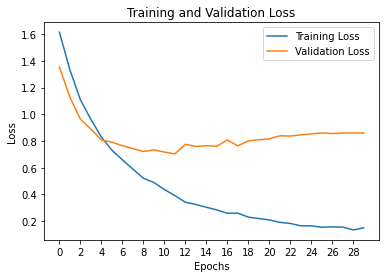

In [11]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()